# 构建数据集

构建自己的数据集

In [3]:
import torch
from torch import nn

torch.__version__

'1.10.0'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 获取自己的数据

机器学习是一个迭代的过程，因此可以从小的数据集开始，如果小的数据集可以跑的通的话，那就可以在必要的时候扩充数据集。


In [5]:
# 下载数据
import requests
import zipfile
from pathlib import Path

# Setup path to data folder ，创建图片保存的地址
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():  # 判断图片地址是否存在
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)  # 如果路径不存在，那就创建文件夹
    
    # 代理服务器设置
    proxies = {
        "http": "http://127.0.0.1:7890",  # 替换为你的代理服务器配置
        "https": "http://127.0.0.1:7890"
    }
    
    # Download pizza, steak, sushi data
    try:
        with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
            print("Downloading pizza, steak, sushi data...")
            request = requests.get(
                "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                verify=False,  # 忽略 SSL 证书验证
                proxies=proxies  # 使用代理下载
            )
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
            print("Unzipping pizza, steak, sushi data...") 
            zip_ref.extractall(image_path)

    except requests.exceptions.RequestException as e:
        print(f"An error occurred during the download: {e}")


data\pizza_steak_sushi directory exists.


### 查看文件结构

In [6]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [8]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir,test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 查看数据
1. 使用 pathlib.Path.glob() 找到所有以 .jpg 结尾的文件，获取所有图片路径。
2. 使用 Python 的 random.choice() 随机选择一个图片路径。
3. 使用 pathlib.Path.parent.stem 获取图片的类别名称。
4. 由于我们在处理图片，所以我们将使用 PIL.Image.open() 来打开随机选择的图片路径（PIL 代表 Python 图像库）。
5. 然后，我们会展示这张图片，并打印一些元数据。


Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


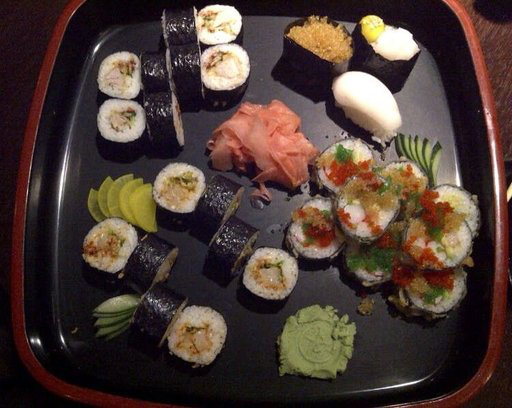

In [9]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

## 数据转换

对自己的数据处理按照以下的步骤来：
1. 将数据转为tensor，这样的话模型可以处理，使用transforms函数
   * torchvision.transforms 有很对在构建模型之前的方法去操控数据，可以将它们转变为tensor，同时可以改变他们的形状，以及进行数据增强。
2. 将数据变为一个dataset，然后使用dataloader去加载数据。
   
多模态数据的dataset：
| Problem space          | Pre-built Datasets and Functions  |
|------------------------|-----------------------------------|
| Vision                 | `torchvision.datasets`            |
| Audio                  | `torchaudio.datasets`             |
| Text                   | `torchtext.datasets`              |
| Recommendation system  | `torchrec.datasets`               |


In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

In [11]:
data_transform = transforms.Compose([
    # 改变图片大小，变为64x64
    transforms.Resize(size=(64, 64)),
    # 数据增强，随机在水平方向翻转
    transforms.RandomHorizontalFlip(p=0.5),
    # 将图片变为tensor类型
    transforms.ToTensor()
])

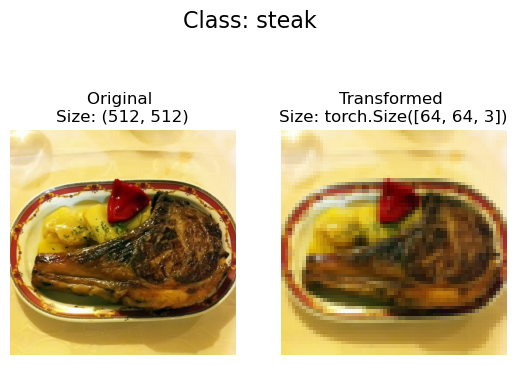

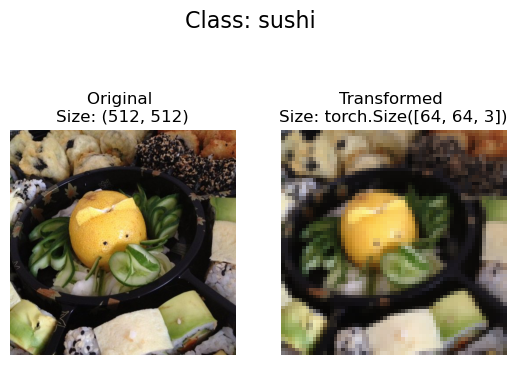

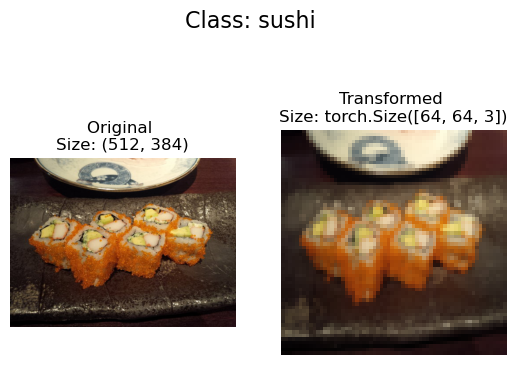

In [12]:
import matplotlib.pyplot as plt
def plot_transformed_imgs(image_paths,transform, n = 3, seed = 44):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths,k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_imgs(image_path_list, 
                      transform=data_transform, 
                      n=3)

## load data
### ImageFolder

当图片所在的文件夹的结构如下所示时，可以使用torchvision.datasets.ImageFolder进行数据导入。
```bash
root/          # 数据集根目录
    class1/    # 类别1的文件夹
        img1.jpg
        img2.jpg
        ...
    class2/    # 类别2的文件夹
        img1.jpg
        img2.jpg
        ...

```

In [13]:
from torchvision import datasets

train_data = datasets.ImageFolder(
    root=train_dir, # 确定该数据集存储的地点
    transform=data_transform, # 是否要对数据进行变换
    target_transform= None # 是否要对标签进行变换
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform = data_transform,

)
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [14]:
'''
classes 属性存储了按字母顺序排列的类名列表。
也就是说，train_data.classes 会返回图像数据集中类别的名称列表。
根据类别子文件夹的名称确定类别数。
'''
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
img,label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


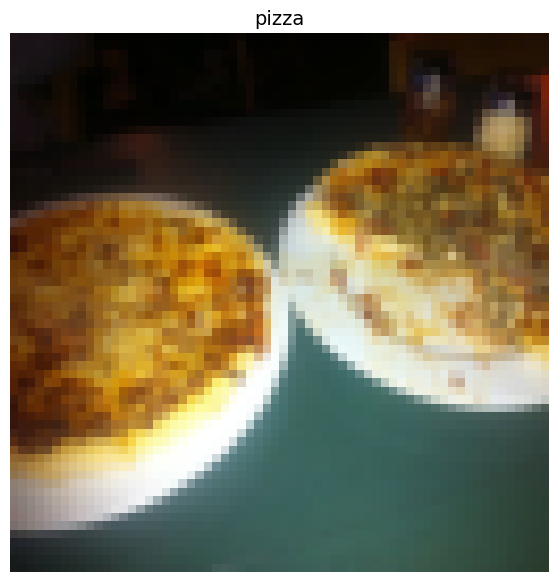

In [17]:
# 注意，使用torch读取的图片是CHW,matplotlib需要的格式是HWC

img_permute = img.permute(1,2,0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [19]:
# 将数据转为模型可以处理的

batch_size = 32

from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              num_workers=8,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             num_workers=8,
                             shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x15d37b8a2b0>,
 <torch.utils.data.dataloader.DataLoader at 0x15d37b8a310>)

In [20]:
# 首先，我们需要使用 DataLoader 来加载数据。通常 DataLoader 是可迭代的，
# 但这里我们手动使用 iter() 函数将其转换为迭代器，以便可以使用 next() 来控制每次迭代。
# next() 会返回一个 tuple，其中包含 (images, labels)，这两个是批次的张量。
img, label = next(iter(train_dataloader))
# Batch size will now be 32, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## ★构建自己的dataset代码

In [21]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [25]:
def find_classes(directory:str) -> Tuple[List]:
    """在目标目录中查找类别文件夹名称。

    假设目标目录采用标准的图像分类格式。

    参数：
        directory (str): 要加载类别名称的目标目录。

    返回值：
        Tuple[List[str], Dict[str, int]]: (类别名称列表, 字典(类别名称: 索引...))

    示例：
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """

    # 1. 扫描目标文件夹，获取类别名称,也就是所有子文件夹的名字
    # 同时后面的判断就是将文件夹中的非文件夹部分排除，这里就是图片

    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2.抛出异常，如果没有找到类别名称的话
    if not classes:
        raise FileNotFoundError(f'{directory}没有找到任何类别')
    
    # 3. 为索引标签创建字典，符合计算机计算的要求
    class_to_idx = {cls_name: i for i,cls_name in enumerate(classes)}
    return classes, class_to_idx

find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [26]:
# 构建自己的Dataset,需要继承属性
from torch.utils.data import Dataset

# 创建自己的数据集类
class MyDataset(Dataset):

    # 初始化参数
    def __init__(self,target_dir:str, transform:None) -> None:
        super().__init__()
        # 超参数初始化
        # 获取该路径下的所有的图片地址
        self.paths = list(pathlib.Path(target_dir).glob('*/*.jpg'))
        # 设置图片的变化
        self.transform = transform
        # 为图片数据创建类别以及索引
        self.classes, self.class_to_idx = find_classes(target_dir)

    # 创建加载图片的函数
    def load_images(self,idx:int) -> Image.Image:
        # 根据index获取图片的地址，然后打开图片
        img_idx = self.paths[idx]
        return Image.open(img_idx)

    # 重写 __len__() 方法
    def __len__(self) -> int:
        return len(self.paths)
    
    # 重写__getitem__()方法
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        # 返回数据的一个样例，以元组的形式返回
        img = self.load_images(index)
        class_name = self.paths[index].parent.name # 只要是一个合法的文件地址就可以这样做
        class_index = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img),class_index
        else:
            return img,class_index

In [28]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_data_custom = MyDataset(target_dir=train_dir, 
                              transform=train_transforms)
test_data_custom = MyDataset(target_dir=test_dir, 
                             transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.MyDataset at 0x15d37dc38b0>, <__main__.MyDataset at 0x15d37dc35b0>)

In [30]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [36]:
train_data_custom.classes,train_data_custom.class_to_idx


0

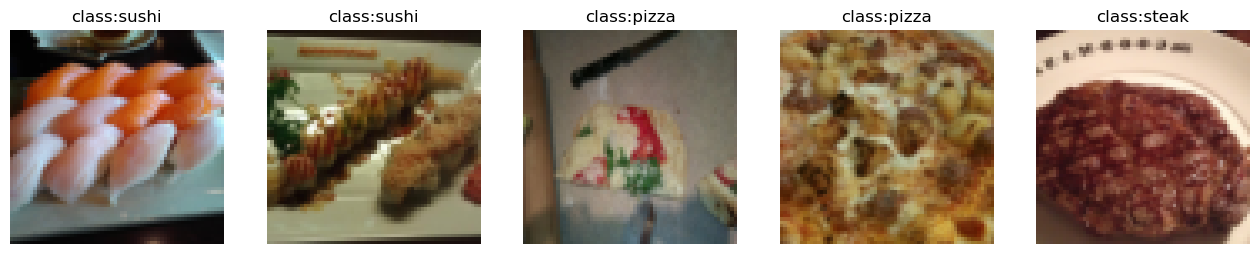

In [38]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # Get Random index
    indexs = random.sample(range(len(dataset)), k=n)

    # set plot figsize 
    plt.figure(figsize=(16,8))

    for i,idx in enumerate(indexs):
        targ_img,targ_label = dataset[idx][0],dataset[idx][1]

        targ_img_adjust = targ_img.permute(1,2,0)

        # 绘制图片
        plt.subplot(1,n,i+1)
        plt.imshow(targ_img_adjust)
        plt.axis('off')
        if classes:
            title = f'class:{classes[targ_label]}'
            if display_shape:
                title = title + f'\n shape:{targ_img_adjust.shape}'

        plt.title(title)

display_random_images(
    train_data_custom,
    n = 5,
    display_shape=False,
    seed=None,
    classes=class_names
)